# Newton's method using variational equations

In [178]:
import rebound
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

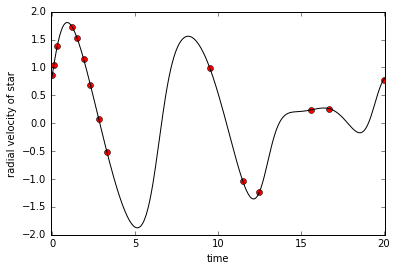

In [23]:
sample_times = np.array([0.,0.1,0.3,1.2,1.5,1.9,2.3,2.8,3.3,9.5,11.5,12.5,15.6,16.7,20.])
def generatedata(x):
    a, e = x
    sim = rebound.Simulation()
    sim.add(m=1.)
    sim.add(primary=sim.particles[0],m=1e-3, a=a, e=e)
    sim.add(primary=sim.particles[0],m=1e-3, a=1.3,f=1.4)
    sim.move_to_com()
    samples = np.zeros((len(sample_times)))
    for i,t in enumerate(sample_times):
        sim.integrate(t)
        samples[i] = sim.particles[0].vx
    return samples
def generateplotpoints(x,N):
    a, e = x
    sim = rebound.Simulation()
    sim.add(m=1.)
    sim.add(primary=sim.particles[0],m=1e-3, a=a, e=e)
    sim.add(primary=sim.particles[0],m=1e-3, a=1.3,f=1.4)
    sim.move_to_com()
    samples = np.zeros((N))
    times = np.linspace(sample_times[0]-0.1,sample_times[-1]+0.1,N)
    for i,t in enumerate(times):
        sim.integrate(t)
        samples[i] = sim.particles[0].vx
    return times, samples
def generatel(x):
    a, e = x
    sim = rebound.Simulation()
    sim.add(m=1.)
    sim.add(primary=sim.particles[0],m=1e-3, a=a, e=e)
    sim.add(primary=sim.particles[0],m=1e-3, a=1.3,f=1.4)
    sim.move_to_com()
    l = 0.
    for i, t in enumerate(sample_times):
        sim.integrate(t)
        rvobs = samples_true[i]
        rv = sim.particles[0].vx
        l += (rv-rvobs)*(rv-rvobs)
    return l
x_true = (1.0,0.2500)
samples_true = generatedata(x_true)
t,s = generateplotpoints(x_true,400)
fig = plt.figure(figsize=(6,4))
ax = plt.subplot(111)
ax.set_xlabel("time")
ax.set_xlim(t[0],t[-1])
ax.set_ylabel("radial velocity of star")
im = ax.plot(sample_times, 1000.*samples_true, "ro")
im = ax.plot(t, 1000.*s, "r-",color="black")
plt.savefig('paper_test3a.pdf',bbox_inches='tight')

In [163]:
def evaluate(x):
    a, e = x
    sim = rebound.Simulation()
    sim.add(m=1.)
    sim.add(primary=sim.particles[0],m=1e-3, a=a, e=e)
    sim.add(primary=sim.particles[0],m=1e-3, a=1.3,f=1.4)
    
    var_da    = sim.add_variation()
    var_dda   = sim.add_variation(order=2,first_order=var_da)
    var_de    = sim.add_variation()
    var_dde   = sim.add_variation(order=2,first_order=var_de)
    var_da_de = sim.add_variation(order=2,first_order=var_da,first_order_2=var_de)
    var_da.vary(1,"a")
    var_de.vary(1,"e")
    var_dda.vary(1,"a")
    var_dde.vary(1,"e")
    var_da_de.vary(1,"a","e")

    sim.move_to_com()
    
    l = 0.
    d = np.zeros((2))
    dd = np.zeros((2,2))
    
    for i, t in enumerate(sample_times):
        sim.integrate(t)
        rvobs = samples_true[i]
        rv = sim.particles[0].vx
        l += (rv-rvobs)*(rv-rvobs)
        d[0] += 2. * var_da.particles[0].vx*(rv-rvobs)
        d[1] += 2. * var_de.particles[0].vx*(rv-rvobs)
        dd[0][0] += 2. * var_dda.particles[0].vx*(rv-rvobs)
        dd[0][0] += 2. * var_da.particles[0].vx*var_da.particles[0].vx
        dd[1][0] += 2. * var_da_de.particles[0].vx*(rv-rvobs)
        dd[1][0] += 2. * var_da.particles[0].vx*var_de.particles[0].vx
        dd[1][1] += 2. * var_dde.particles[0].vx*(rv-rvobs)
        dd[1][1] += 2. * var_de.particles[0].vx*var_de.particles[0].vx

    dd[0][1] = dd[1][0]
             
    return l, d, dd

In [188]:
def evaluate_shadow(x, d=(1e-6,1e-6)):
    a, e = x
    d_a, d_e = d
    sim = rebound.Simulation()
    sim.add(m=1.)
    sim.add(primary=sim.particles[0],m=1e-3, a=a, e=e)
    sim.add(primary=sim.particles[0],m=1e-3, a=1.3,f=1.4)
    sim.move_to_com()
    
    sim_a = rebound.Simulation()
    sim_a.add(m=1.)
    sim_a.add(primary=sim_a.particles[0],m=1e-3, a=a+d_a, e=e)
    sim_a.add(primary=sim_a.particles[0],m=1e-3, a=1.3,f=1.4)
    sim_a.move_to_com()

    sim_e = rebound.Simulation()
    sim_e.add(m=1.)
    sim_e.add(primary=sim_e.particles[0],m=1e-3, a=a, e=e+d_e)
    sim_e.add(primary=sim_e.particles[0],m=1e-3, a=1.3,f=1.4)
    sim_e.move_to_com()

    sim_aa = rebound.Simulation()
    sim_aa.add(m=1.)
    sim_aa.add(primary=sim_aa.particles[0],m=1e-3, a=a-d_a, e=e)
    sim_aa.add(primary=sim_aa.particles[0],m=1e-3, a=1.3,f=1.4)
    sim_aa.move_to_com()

    sim_ee = rebound.Simulation()
    sim_ee.add(m=1.)
    sim_ee.add(primary=sim_ee.particles[0],m=1e-3, a=a, e=e-d_e)
    sim_ee.add(primary=sim_ee.particles[0],m=1e-3, a=1.3,f=1.4)
    sim_ee.move_to_com()

    sim_ea1 = rebound.Simulation()
    sim_ea1.add(m=1.)
    sim_ea1.add(primary=sim_ea1.particles[0],m=1e-3, a=a+d_a, e=e-d_e)
    sim_ea1.add(primary=sim_ea1.particles[0],m=1e-3, a=1.3,f=1.4)
    sim_ea1.move_to_com()

    sim_ea2 = rebound.Simulation()
    sim_ea2.add(m=1.)
    sim_ea2.add(primary=sim_ea2.particles[0],m=1e-3, a=a-d_a, e=e+d_e)
    sim_ea2.add(primary=sim_ea2.particles[0],m=1e-3, a=1.3,f=1.4)
    sim_ea2.move_to_com()

    sim_ea3 = rebound.Simulation()
    sim_ea3.add(m=1.)
    sim_ea3.add(primary=sim_ea3.particles[0],m=1e-3, a=a+d_a, e=e+d_e)
    sim_ea3.add(primary=sim_ea3.particles[0],m=1e-3, a=1.3,f=1.4)
    sim_ea3.move_to_com()

    sim_ea4 = rebound.Simulation()
    sim_ea4.add(m=1.)
    sim_ea4.add(primary=sim_ea4.particles[0],m=1e-3, a=a-d_a, e=e-d_e)
    sim_ea4.add(primary=sim_ea4.particles[0],m=1e-3, a=1.3,f=1.4)
    sim_ea4.move_to_com()



    
    
    
   
    d = np.zeros((2))
    dd = np.zeros((2,2))


    
    for i, t in enumerate(sample_times):
        sim.integrate(t)
        sim_a.integrate(t)
        sim_e.integrate(t)
        sim_aa.integrate(t)
        sim_ee.integrate(t)
        sim_ea1.integrate(t)
        sim_ea2.integrate(t)
        sim_ea3.integrate(t)
        sim_ea4.integrate(t)


        rvobs = samples_true[i]
        rv = sim.particles[0].vx
        
        rv_da = (sim_a.particles[0].vx-sim.particles[0].vx)/d_a
        rv_de = (sim_e.particles[0].vx-sim.particles[0].vx)/d_e
        
        rv_da_de = (sim_ea3.particles[0].vx-sim_ea1.particles[0].vx-sim_ea2.particles[0].vx+sim_ea4.particles[0].vx)/(4.*d_e*d_a)
        rv_daa = (sim_a.particles[0].vx-2.*sim.particles[0].vx+sim_aa.particles[0].vx)/(d_a*d_a)
        rv_dee = (sim_e.particles[0].vx-2.*sim.particles[0].vx+sim_ee.particles[0].vx)/(d_e*d_e)
        
        
        dd[0][0] += 2. * rv_daa*(rv-rvobs)
        dd[0][0] += 2. * rv_da*rv_da
        dd[1][0] += 2. * rv_da_de*(rv-rvobs)
        dd[1][0] += 2. * rv_da*rv_de
        dd[1][1] += 2. * rv_dee*(rv-rvobs)
        dd[1][1] += 2. * rv_de*rv_de
        
        d[0] += 2. * rv_da*(rv-rvobs)
        d[1] += 2. * rv_de*(rv-rvobs)
    
    dd[0][1] = dd[1][0]


             
    return d,dd

In [165]:
print(evaluate((0.951,0.12))[2])
print(evaluate_shadow((0.951,0.12),(1e-8,1e-3))[1])

[[ 0.00168213 -0.00013156]
 [-0.00013156 -0.00032706]]
[[ 0.00141691  0.00075587]
 [ 0.00075587 -0.00032477]]


In [207]:
N=200
grid_a = np.logspace(-16.,-1.5,N)
grid_e = np.logspace(-16.,-1.5,N)
d_var = evaluate((0.951,0.12))[1]
dd_var = evaluate((0.951,0.12))[2]
d_sha = np.zeros((N,N,2))
dd_sha = np.zeros((N,N,3))
for i, a in enumerate(grid_a):
    for j, e in enumerate(grid_e):
        res = evaluate_shadow((0.951,0.12),d=(a,e))
        resabs = np.abs((res[0]-d_var))
        #print(("%e %e %e %e") %(a,e,resabs[0]/np.abs(d_var[0]), resabs[1]/np.abs(d_var[1])))
        d_sha[i][j][0] = resabs[0]/np.abs(d_var[0])
        d_sha[i][j][1] = resabs[1]/np.abs(d_var[1])
        dd_sha[i][j][0] = np.abs((res[1][0][0]-dd_var[0][0])/dd_var[0][0])
        dd_sha[i][j][1] = np.abs((res[1][1][1]-dd_var[1][1])/dd_var[1][1])
        dd_sha[i][j][2] = np.abs((res[1][0][1]-dd_var[0][1])/dd_var[0][1])


/Users/rein/git/rebound/venv/lib/python3.4/site-packages/matplotlib/image.py:375: UserWarning: Images are not supported on non-linear axes.
  warnings.warn("Images are not supported on non-linear axes.")


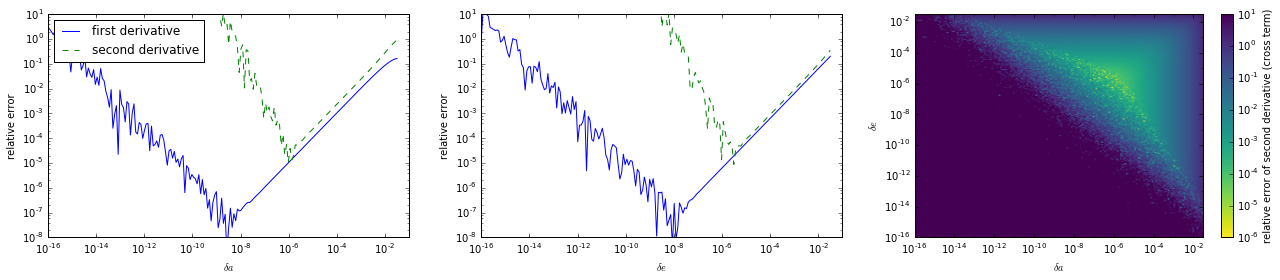

In [228]:
fig = plt.figure(figsize=(22,4))
ax = plt.subplot(131)
extent = [min(grid_a),max(grid_a)]
#ax.set_xlim(extent[0],extent[1])
ax.set_xlabel("$\delta a$")
ax.set_ylim(1e-8,1e1)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel("relative error")
ax.plot(grid_a, d_sha[:,0,0],label="first derivative")
ax.plot(grid_a, dd_sha[:,0,0],"--",label="second derivative")
legend = plt.legend(loc=2)
ax = plt.gca().add_artist(legend)

ax = plt.subplot(132)
extent = [min(grid_a),max(grid_a)]
#ax.set_xlim(extent[0],extent[1])
ax.set_xlabel("$\delta e$")
ax.set_ylim(1e-8,1e1)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel("relative error")
ax.plot(grid_e, d_sha[0,:,1])
ax.plot(grid_e, dd_sha[0,:,1]+2.*grid_e,"--")

ax = plt.subplot(133)
extent = [min(grid_a),max(grid_a),min(grid_e),max(grid_e)]
#ax.set_xlim(extent[0],extent[1])
ax.set_ylabel("$\delta e$")
ax.set_xlabel("$\delta a$")
ax.set_xscale("log")
ax.set_yscale("log")
import matplotlib.ticker as plticker
loc = plticker.LogLocator(numticks=10) 
ax.xaxis.set_major_locator(loc)
ax.yaxis.set_major_locator(loc)
im = ax.imshow((dd_sha[:,:,2]), vmax=1e1, vmin=1e-6, cmap="viridis_r", origin="lower",norm=LogNorm(),aspect='auto', extent=extent) #interpolation="none",
cb = plt.colorbar(im, ax=ax)
cb.set_label("relative error of second derivative (cross term)")



plt.savefig('paper_test4.pdf',bbox_inches='tight')